In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from scipy import stats
import numpy as np
import network_dataloader as ndl
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


## Get pretrained model

In [2]:
net = models.vgg16(pretrained=True, progress=True).to(device=device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/xdg-cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 183MB/s]  


## Modify the last layer to output the same as input

In [3]:
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
net.classifier[6] = Identity()

## Get dataset

In [4]:
batchSize = 46
input_size = 224
# Load Data
data_transforms = {
        'train': transforms.Compose([
                ndl.Rescale(input_size),
                ndl.ToTensor()]), 
        'test': transforms.Compose([
                ndl.Rescale(input_size),
                ndl.ToTensor()])
        }

print("Initializing Datasets and Dataloaders...")

# Create training and testing datasets
image_datasets = {x: ndl.TopoplotLoader('images', x, data_transforms[x]) for x in ['train', 'test']}

# Create training and testing dataloaders
dataloaders_dict = {'train': Data.DataLoader(image_datasets['train'], batch_size=batchSize, shuffle=True, num_workers=4),
                    'test':  Data.DataLoader(image_datasets['test'], batch_size=batchSize, shuffle=False, num_workers=4)}

Initializing Datasets and Dataloaders...
> Found 369 images...
> Found 42 images...


## Extract features by VGG16 

In [5]:
net.eval() # Disable batchnorm, dropout

# Training data
for i_samples, samples in enumerate(dataloaders_dict['train']):
    imgs = samples['image'].to(device=device)
    labels = samples['label'].to(device=device)
    
    if i_samples == 0:
        with torch.no_grad():
            X_train = net(imgs).cpu().numpy()
        Y_train = labels.cpu().numpy()
    else:
        with torch.no_grad():
            X_train = np.concatenate((X_train, net(imgs).cpu().numpy()), axis=0)
        Y_train = np.concatenate((Y_train, labels.cpu().numpy()), axis=0)
    
print('X_train shape : ', X_train.shape)
print('Y_train shape : ', Y_train.shape)
    
# Testing data
for samples in dataloaders_dict['test']:
    imgs = samples['image'].to(device=device)
    labels = samples['label'].to(device=device)
    
    with torch.no_grad():
        X_test = net(imgs).cpu().numpy()
    Y_test = labels.cpu().numpy()
    
print('X_test shape : ', X_test.shape)
print('Y_test shape : ', Y_test.shape)
    


X_train shape :  (369, 4096)
Y_train shape :  (369,)
X_test shape :  (42, 4096)
Y_test shape :  (42,)


## Apply PCA to reduct dimension

In [6]:
pca = PCA(n_components=0.9, svd_solver='full')
pca.fit(X_train)

X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)

print('X_train_PCA shape : ', X_train_PCA.shape)
print('X_test_PCA shape : ', X_test_PCA.shape)

X_train_PCA shape :  (369, 11)
X_test_PCA shape :  (42, 11)


In [7]:
pca.explained_variance_

array([76.42907  , 14.145529 ,  5.715878 ,  4.8585453,  2.3922083,
        2.1910827,  1.8846282,  1.6269903,  1.405655 ,  1.1774825,
        0.9284946], dtype=float32)

## Regression to predict solution time

In [8]:
def plot_scatter(true, pred):
    # Sort SLs in increasing order
    sorted_indices = np.argsort(true)
    sorted_true = true[sorted_indices]
    sorted_pred = pred[sorted_indices]

    max_value = np.max(np.hstack((true, pred)))
    plt.scatter(sorted_true, sorted_pred, marker='.')
    axes = plt.gca()
    axes.set_xlim([0, max_value])
    axes.set_ylim([0, max_value])
    plt.xlabel('True')
    plt.ylabel('Pred')

In [9]:
X_train_Reg = X_train_PCA
X_test_Reg = X_test_PCA
clf = linear_model.LinearRegression()
clf.fit(X_train_Reg, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

R squared: 0.174057
Standard error: 5.078143


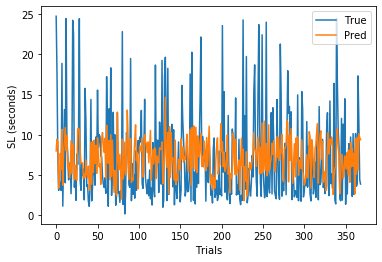

In [10]:
num_train = len(Y_train)
pred_train = clf.predict(X_train_Reg).flatten()
plt.plot(range(num_train), Y_train)
plt.plot(range(num_train), pred_train)
plt.xlabel('Trials')
plt.ylabel('SL (seconds)')
plt.legend(('True', 'Pred'))

print('R squared: %f'%(r2_score(Y_train, pred_train)))
print('Standard error: %f'%(mean_squared_error(Y_train, pred_train)**0.5))

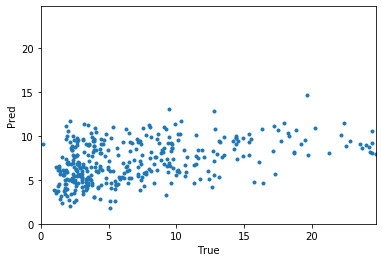

In [11]:
plot_scatter(Y_train, pred_train)

R squared: 0.121760
Standard error: 5.052654


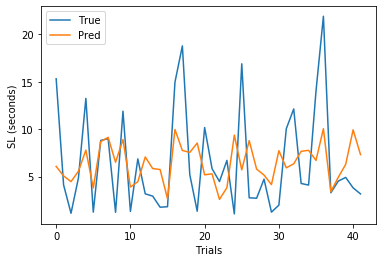

In [12]:
num_test = len(Y_test)
pred_test = clf.predict(X_test_Reg).flatten()
plt.plot(range(len(Y_test)), Y_test)
plt.plot(range(len(Y_test)), pred_test)
plt.xlabel('Trials')
plt.ylabel('SL (seconds)')
plt.legend(('True', 'Pred'))

print('R squared: %f'%(r2_score(Y_test, pred_test)))
print('Standard error: %f'%(mean_squared_error(Y_test, pred_test)**0.5))

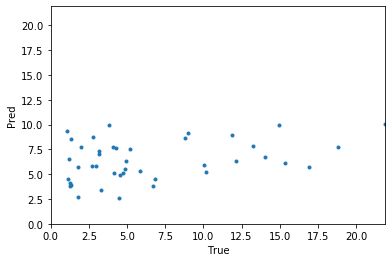

In [13]:
plot_scatter(Y_test, pred_test)

# Read result from mynet

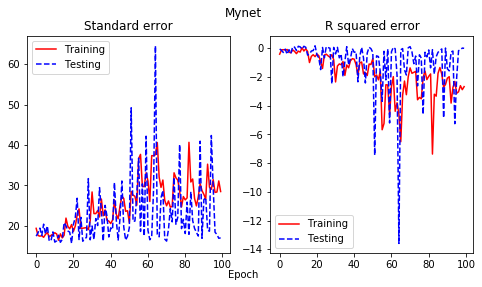

In [2]:
# Load training error data
with open('error.data', 'rb') as fp:
    dict_error = pickle.load(fp)
    
epoch = list(range(len(dict_error['train_std'])))
fig, axs = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('Mynet')

axs[0].plot(epoch, dict_error['train_std'], 'r-', epoch, dict_error['test_std'], 'b--')
axs[0].set_title('Standard error')
axs[0].legend(('Training', 'Testing'))
axs[1].plot(epoch, dict_error['train_r2'], 'r-', epoch, dict_error['test_r2'], 'b--')
axs[1].set_title('R squared error')
axs[1].legend(('Training', 'Testing'))

fig.text(0.5, 0.04, 'Epoch', ha='center')
fig.savefig('./results/vgg16_SMOTER.png')